# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$

## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [4]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum

In [5]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
N = 300
controls = np.zeros((N,1))
x_init = np.array([[1.0],[0.]])
pendulum.animate_robot(x_init, controls.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUMdtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DyNliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwANdenHSEFz8V9D0Huo6ra97jI0pgHWEgrm6XJ7eYN6T82kB9cDqoIFcQ1W8kYaaar
yB7R9dic4xvVnQpgkTkdJZH7yx7IyIimVgTUYPxFhDkBW+UMQNi3powsubwa8KN+BHTvqeuCVs4q
TK8Sutw9A6fePtWv8tSIuP258+p2cIDR/HoC502qtOvrz43hPJ3RUUchP/jkMpYOAy1Lq6sK90AL
oF/Oz4Y1ENQ0i2f1glYXnTFd9k3tViIdvhb8Obtv7u7iLxCIv9vzQG8cc1UVLjaVsH7ZnK4N5rFX
+S3GOaxueDO1Nb5iZFKf4UCDbOhvAj75MVtksfR3JzBVSAbTfGts8KG1SXaqTbErXeNnOT5oFoRF
My+S3eTi77iSzj2q3EmNsIxs21bEdBcl71p8vzq511yFGcWbDEN4FKS7Jz/9EwQoVOA3uD4tg7uu
OY52hXScuuMUX+CgkMdOfPcei3PS20pCmz0zw66l64ib40sX2ZwyGg/6VY/MQzg46+eia3VF316p
qGZ40EHKxb/w5HREA74r94CB8BSe88TrCM7pngcFlYK4xv+QMkelDZkGNN0uUJAz8SYO0s6QpRlN
5q6Ux2VKXsjVTjSRZjqbm3mbtjXD/Vr3+xX9mExhBDqqAJmeqbRnjJUncwhTUEHD3figVAUWh3Ib
47BAAAADAAADAAADAB1K1loljQZGrN+Vn0H+OPU7SeKRX/DL2dhdi1aMQz+rvFzGmMZ5ZIb+lYsE
FKQLIVBmI9hjfgnEzX7MEP6DeC+K792YzjZK8T0i9zCdmp/1vD5nV039wTJxmKrIfDHXc6RIiwhe
S5Sj8qDQCr69h/PU0xLy1EAID0ZjFFYLWEnuibFfBrFLILbigzRRNQGScLYlXKDtQ203Z1b1X1lf
Os+qNAblm/Y+8BOs/0pQ3cNQ4iDr3deP1CyO21Cj/bMt48ceHRnpGZlLtczc0gsjPZ3kHIMcgZWB
d+7o6mkQrVyDwKPiDfs3XDRVuwVrGT1+T+5D0R9Ojb1EI7yYaM2uCLj0LfVIjn3UXo1TfUePBN1j
IgeXWDj3yK9V5N1tkCgtto6YlAU9R9IYo3QL1Lv/5l5MUVPKUgJH7QV4p1Iy6NoAAAMAAAMAAAMC
QrKQDgwJc7HhSPWV8uhiNsu4IFM402Nvq4Ml20KhEQzPJdjSjW/4Szt+T0TjztnDaZ0oMQVDmB6R
1T4gFFhA0fbgd/QEUhQGENg2YuBR8l4wRCfHJYVh2jNX3Elwszk2mlzQfYmVehFgaZSq9basuhXi
f4U4wxdFewwEdKnr1wWuoQArHQ/z+/s4G0XmVGOTAMiaxmP3xGvP+Hk2RVkSayUeuiIbQwziY4mV
W4Hul6v6Rzz3loYRP7mMHUWdNLBIOZtox/vMQuxaicdV6fcKzudlMzKRAZF3p5s6njmaaqsx7izX
y/nedNgfBhdFAzR8u0CNdQP/M63r/BNhCLxzYIZPcu7GbSyXM71V2DzjAFjitiq1lG/Ri26lF9vk
YoJB8dcLjvW00TQLLqWIJX9Xmw59Wqg8tzmbnw24HLd9lKzISzJQ4aS8H8kYqu0/o513F/FVACEG
1aMFa6aPCgLsa7Jq0No7dueM5sRY1wdg5PGjV/iCKAdYgzJ7pIJLnOPnZc6eiSNddy3yZSyAfgt8
/ovE76KNezBBeVPj6af3Dydv08GjvF4EcKQuSUSRFFiR4VvInz9KI5uGih8T1Wph3HoYej1AC0Yt
ZbtHfZAzjyIRCt3BO4263HP6issgryuX+7LQn5xlThPC7T9vrWuYbSRzOAgS6BFESCUF1YSb0Tt7
l7Pf8jTUYfVH3OqP3eBbQQfiMVeL/ho+U0guP+tzbnvfe9+ZVBloU6gnEHA+Li2PXQQN5ICHEabE
DcVw0CZG+9y+ftUKSD6W4Q6eiV1lqSCkMryqq0Xb+es05QyvWnjJPQpZinmuyelCMoVCX7yhWKX+
0wV3Gco1rrQaNyi5RE/2h09oycnKQbf4LaeKedyxCJ/FX1gdiXNi8o6kfGQvuUR2C7yGFyDCR7OC
9LhOAzw0mDm4boFxRGnoKfpd10Jr79Kcca1WZZcDQJlWYbNBSE+Y/ARMCcaxydQJqAE0XP4GjQWy
2OeFu0LOex1Y+zq4lUVPfQh17yIk/IcTFSz8/IR+PVQnR5gQLCDdmi2VCO3tuhgO6+xeupnE149K
egMvUYjen+u1sh3+nX0b28d02lpj//qMNXRgwf9u7otWKsoVaIBFDk7P4NwD4PiiyJfuZ/Gs/4yZ
ZWlb+MajHy/W9KKrg/9N5GDubrxmSNeLUoz+e0nyBUk9TxibW8s5K5SUBSGbpbxoljlXaO2ihFht
ItckYHIEGOAFotgAnznfImQ6HO5mM+nQFoLP7eXxO2mkeqsW3tkpbZkRt5z4lN+pZxfU00dnM6Dv
Z0GBTDtVG+J38ruldNtaDubt4D8FOfR9zs0/pXPttRo1kEwjd9NYkpJ5l3uCxMJq3FDFeFe//Bms
DrZMUzGSno3N4ZagiWBFU7XnUNkQMqMaEiGyR1oTyj5uIZFk1sZ4ZHTcycDKxw8cvI4p/bD3v5Yq
TaWvMR/2islo2+pS23OxJ6uem5mF9zkS/RLe3VSBZwyJP5lv9PzFCNbhstflIC76TCqS2lorZ8Og
KJmYe2TuIrjT1/5PazWbaJJKdUAA2AU2TDUfQQLDghe20d5B9iuWnczcYeqVacKCQjlGSVYwzCEn
4NDOkhMoJJnv+dyf1q1O/8QaiEhZzf/rZ/Rk1B9VtbQ+q20Jq1Qdlg1SKIcGDw6s4ksY4kZfsLot
NtkCi//UVnJjHW5uTt2ap

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUMdtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DyNliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwANdenHSEFz8V9D0Huo6ra97jI0pgHWEgrm6XJ7eYN6T82kB9cDqoIFcQ1W8kYaaar
yB7R9dic4xvVnQpgkTkdJZH7yx7IyIimVgTUYPxFhDkBW+UMQNi3powsubwa8KN+BHTvqeuCVs4q
TK8Sutw9A6fePtWv8tSIuP258+p2cIDR/HoC502qtOvrz43hPJ3RUUchP/jkMpYOAy1Lq6sK90AL
oF/Oz4Y1ENQ0i2f1glYXnTFd9k3tViIdvhb8Obtv7u7iLxCIv9vzQG8cc1UVLjaVsH7ZnK4N5rFX
+S3GOaxueDO1Nb5iZFKf4UCDbOhvAj75MVtksfR3JzBVSAbTfGts8KG1SXaqTbErXeNnOT5oFoRF
My+S3eTi77iSzj2q3EmNsIxs21bEdBcl71p8vzq511yFGcWbDEN4FKS7Jz/9EwQoVOA3uD4tg7uu
OY52hXScuuMUX+CgkMdOfPcei3PS20pCmz0zw66l64ib40sX2ZwyGg/6VY/MQzg46+eia3VF316p
qGZ40EHKxb/w5HREA74r94CB8BSe88TrCM7pngcFlYK4xv+QMkelDZkGNN0uUJAz8SYO0s6QpRlN
5q6Ux2VKXsjVTjSRZjqbm3mbtjXD/Vr3+xX9mExhBDqqAJmeqbRnjJUncwhTUEHD3figVAUWh3Ib
47BAAAADAAADAAADAB1K1loljQZGrN+Vn0H+OPU7SeKRX/DL2dhdi1aMQz+rvFzGmMZ5ZIb+lYsE
FKQLIVBmI9hjfgnEzX7MEP6DeC+K792YzjZK8T0i9zCdmp/1vD5nV039wTJxmKrIfDHXc6RIiwhe
S5Sj8qDQCr69h/PU0xLy1EAID0ZjFFYLWEnuibFfBrFLILbigzRRNQGScLYlXKDtQ203Z1b1X1lf
Os+qNAblm/Y+8BOs/0pQ3cNQ4iDr3deP1CyO21Cj/bMt48ceHRnpGZlLtczc0gsjPZ3kHIMcgZWB
d+7o6mkQrVyDwKPiDfs3XDRVuwVrGT1+T+5D0R9Ojb1EI7yYaM2uCLj0LfVIjn3UXo1TfUePBN1j
IgeXWDj3yK9V5N1tkCgtto6YlAU9R9IYo3QL1Lv/5l5MUVPKUgJH7QV4p1Iy6NoAAAMAAAMAAAMC
QrKQDgwJc7HhSPWV8uhiNsu4IFM402Nvq4Ml20KhEQzPJdjSjW/4Szt+T0TjztnDaZ0oMQVDmB6R
1T4gFFhA0fbgd/QEUhQGENg2YuBR8l4wRCfHJYVh2jNX3Elwszk2mlzQfYmVehFgaZSq9basuhXi
f4U4wxdFewwEdKnr1wWuoQArHQ/z+/s4G0XmVGOTAMiaxmP3xGvP+Hk2RVkSayUeuiIbQwziY4mV
W4Hul6v6Rzz3loYRP7mMHUWdNLBIOZtox/vMQuxaicdV6fcKzudlMzKRAZF3p5s6njmaaqsx7izX
y/nedNgfBhdFAzR8u0CNdQP/M63r/BNhCLxzYIZPcu7GbSyXM71V2DzjAFjitiq1lG/Ri26lF9vk
YoJB8dcLjvW00TQLLqWIJX9Xmw59Wqg8tzmbnw24HLd9lKzISzJQ4aS8H8kYqu0/o513F/FVACEG
1aMFa6aPCgLsa7Jq0No7dueM5sRY1wdg5PGjV/iCKAdYgzJ7pIJLnOPnZc6eiSNddy3yZSyAfgt8
/ovE76KNezBBeVPj6af3Dydv08GjvF4EcKQuSUSRFFiR4VvInz9KI5uGih8T1Wph3HoYej1AC0Yt
ZbtHfZAzjyIRCt3BO4263HP6issgryuX+7LQn5xlThPC7T9vrWuYbSRzOAgS6BFESCUF1YSb0Tt7
l7Pf8jTUYfVH3OqP3eBbQQfiMVeL/ho+U0guP+tzbnvfe9+ZVBloU6gnEHA+Li2PXQQN5ICHEabE
DcVw0CZG+9y+ftUKSD6W4Q6eiV1lqSCkMryqq0Xb+es05QyvWnjJPQpZinmuyelCMoVCX7yhWKX+
0wV3Gco1rrQaNyi5RE/2h09oycnKQbf4LaeKedyxCJ/FX1gdiXNi8o6kfGQvuUR2C7yGFyDCR7OC
9LhOAzw0mDm4boFxRGnoKfpd10Jr79Kcca1WZZcDQJlWYbNBSE+Y/ARMCcaxydQJqAE0XP4GjQWy
2OeFu0LOex1Y+zq4lUVPfQh17yIk/IcTFSz8/IR+PVQnR5gQLCDdmi2VCO3tuhgO6+xeupnE149K
egMvUYjen+u1sh3+nX0b28d02lpj//qMNXRgwf9u7otWKsoVaIBFDk7P4NwD4PiiyJfuZ/Gs/4yZ
ZWlb+MajHy/W9KKrg/9N5GDubrxmSNeLUoz+e0nyBUk9TxibW8s5K5SUBSGbpbxoljlXaO2ihFht
ItckYHIEGOAFotgAnznfImQ6HO5mM+nQFoLP7eXxO2mkeqsW3tkpbZkRt5z4lN+pZxfU00dnM6Dv
Z0GBTDtVG+J38ruldNtaDubt4D8FOfR9zs0/pXPttRo1kEwjd9NYkpJ5l3uCxMJq3FDFeFe//Bms
DrZMUzGSno3N4ZagiWBFU7XnUNkQMqMaEiGyR1oTyj5uIZFk1sZ4ZHTcycDKxw8cvI4p/bD3v5Yq
TaWvMR/2islo2+pS23OxJ6uem5mF9zkS/RLe3VSBZwyJP5lv9PzFCNbhstflIC76TCqS2lorZ8Og
KJmYe2TuIrjT1/5PazWbaJJKdUAA2AU2TDUfQQLDghe20d5B9iuWnczcYeqVacKCQjlGSVYwzCEn
4NDOkhMoJJnv+dyf1q1O/8QaiEhZzf/rZ/Rk1B9VtbQ+q20Jq1Qdlg1SKIcGDw6s4ksY4kZfsLot
NtkCi//UVnJjHW5uTt2ap

C:\Users\Jainam\AppData\Local\Temp\ipykernel_25676\2345752551.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_expanded[current_size, 0] = residual_theta
C:\Users\Jainam\AppData\Local\Temp\ipykernel_25676\2345752551.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_expanded[current_size + 1, 0] = residual_omega


Total iterations completed = 4


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMbBtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DPhliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHPPpeuCVceyT
K8Sutw9A6fdPtZ/8tSIN4rY0xxRToEK/HoC502qtOxtzT5Rshcw28vw//QkicWHkwCvzecFArvQA
Z4MWgQU+vHJzSLZ/WCVhedMV3wTe1YYce+Fvw5u2/u7uIvEIbe2/NAbxxzVRUuNpWvttmcrg3msV
f5LcY5rFJ4MYGYQxi87O/T99PIv/k3PvUw/mSx8k0JkuhIBtN8a2zwqrVJdqpNsStd42c5PmgULd
lXI9If0lw84YdjaqR9NBthGNm2rYjoLkvetPu+d1OuuQIzizYYhvApSXZOLWiG3klxgOje3Xql1H
zwkwMjtepmqdGqRF6m8dIt8EWdmJfRbpmzmBZZ+9M8MsE7HlxnwnwJZZkfxoVSLH4yNuhC1vTze9
8ZKl0MHCCbzIiHK10aUpSrmBEgiXAsdQaDTmNy+bLHkTelWLyXHJhN/fZG0j50ilw0NLlCQM/EmD
skQWKUZTeaulMdlSl6uRdcjYFdAzFPIfBRxk+npMwoVGVgSKo+IMTavpWXi13GNYzp8Sb585YqNd
QbE05LKCNMSsXuL0HY6NhYRGEAyBI+QLeCADS4ArBMne8jsbLgX+QbYbn7wlh0mTNCgzFuDL2dhd
i1aMQz+ru3FGmMZ5ZIb+lYsAjsAOkVBmPncoa1yt/2cYHH9Bu6d+d+7MZxsleJ5egLLC0jr7Mxim
FvWh6Q5h48QCf4dX2PjZ0sIXkuUo/Kgz855JoK/2tMS8tQ/kFU5qknzUcr/kx6M5K798uawj7FvS
RLWjqo/YD4aQ8X85oOVb19ZXzrESjRK5jGgVPATrP9KUN3Cct+71Y7rx+oWR22lcf5yJApOiZpI6
vruqfrmhpTpuZ7O8g5BjkDKvX/4208yucYKh0NWcJcbAGiY1Vg36L8tH7tcpOaDFh+q+cQfz5l4B
LD8peBZbNIZqzOkidsmQKBcpHrYMXLbQ/pBEf6cfxsamQfL0wuA3S6vztQjnl7ye//bDwpGHRa6I
FiuOob0kLH09dl+dCYUw6gX3atxQ4EVFcybKfIGVHJ2AB8w2SNEeq7mRuDs+x7YedvDlkdqnDXhO
RYBFt/BhbVerbmzSuKQikKNNYIFB+T0TjztnDaZyTK+ZZzA9I6p76ZSWDWztwO/oCKQoNmAQbRJ/
f3y8YIhO+wu3oSYxhKVCmn5GU6dv+5UUVdm1wlmzJcxa9QBzbPn0AwxdFewzG0jvvSwJ0shL36/9
F+OGUj3K/gsOUrZB8EGP3xGvP+Hk41qe0t/fMmScmQEhWmSWQ/rEUo6Vf0kDZgGfV8M3ZVeNBIOs
trwfl5JFym1M7hH2e58YlOHwbRy2K8ayymzfmQjYe4JNzwXuJG1ymm+WapXEntAhAUpbSSnoQABv
irNdyp31oF7uSDfOAx8q/1TuqMXDjAf7jnkvtH6dLTBO/8nMPafK8rITYu3Cl8V9+OhF6JSwHpur
J4HJDk6wQpjUvj6uktpwfb8fZQvTYWYrP8r769NiQY/ffPbKcNU0NozWCfBRxnRs6UicJ9l4SkDl
3JCn03xh3h3xk1AOUPfJ1NE3WslBp+SPShyLh6SMjsdB6APzdKj4H7hXENPHIEdbYvAkryHejI0I
5kcUp5h2pTQ1axmi4Ip5TQPzd9oF7ytIzRMzjlFIImiNCDaK7bSajDn/+Ke62zcgPXBcClWs/bHM
cIKp27xIK7xVjE8cLunJtpivYN0OVyOUx3p7plaROt5ZTBUovZ4RZ4xVN3rd1N9mBNAfruQLQ+mM
C8uktBuMPgSpryprvnwCL1uOFMNOr/A6oKcquKtF1KZCYx1Yix7bvbdLwoLfJDWd+tHaPFWKs1Qa
uhQlou3gWp7H/29nhov9/4nPLJ5KY0r0ceSDmlbZhw6DPOMiB+mABC9Q+v7XHlzPKz7VxSG5hzeN
XYxFxfiyqt05oIIvWwk2NwLhz1Wux6TKcakokqHTfyjkl18HUME7lLsuupjIKstAmMsH7ogEiMiI
DiqBfKJeuf8K1eLFTVXuS/6RUAz//sUOynmEmHupo/OCsVOeYEdT5/kx2cdl+1eX6qS6Wu1OCkfh
oZSHfJ2kDyNxlPrd8WXLJVmd1mObxoGYwfdI0yiMNFqjVkc3/CtloHNZ9L3TlQzv5CDy5DZHW90r
Wqxij7WNLAADeQ+KavGcKXsYxmK770vlQc4RvzMAABybdhBMdIg5H+3TlkrHFxmnVIzGUQKHZFNj
5Qqs1LAOnE1xnPbkGq1g2yvxr5LQcFg6G7xDJfUVFPyBLj85JvtiVoXEZUi3Hn/8uqk8GxD7B+cJ
8RTA3PdxOfTzgN+woY/rUh8wL/2P9SUE0N+9z3zu/7D213MbaVmeAEHMslA+43eg2D2Wze7zoIVe
/yb5nyuOqcVDaCEeNokuXOrCRozbJ4KQycUrmkHTDz7DVuUBZFF99C4YH2SIfCbW5/EvFMgtwZgo
SoRhryff0/Cm3/G33xK4e+asvuc+iz/yIV2KPoNpJECaobzRIjYMws8i0MmYr4rlBgnCyOU07ukR
YklIUPW5Irc3ZKiJY4i8pbbmf+JKeUzvP1+Ecac1BfqC1SSIRiBOkulT/gxakSC5FB+eK0LzG5EW
b9UDZ55//shGdCMeztwyY62U2LEcjYk7izS6p7VWuTgm/U+vfrlo0eVnfAI9toQ94hDF93LX55YL
IXmc6KXuoAwM9Vx+4D2hy

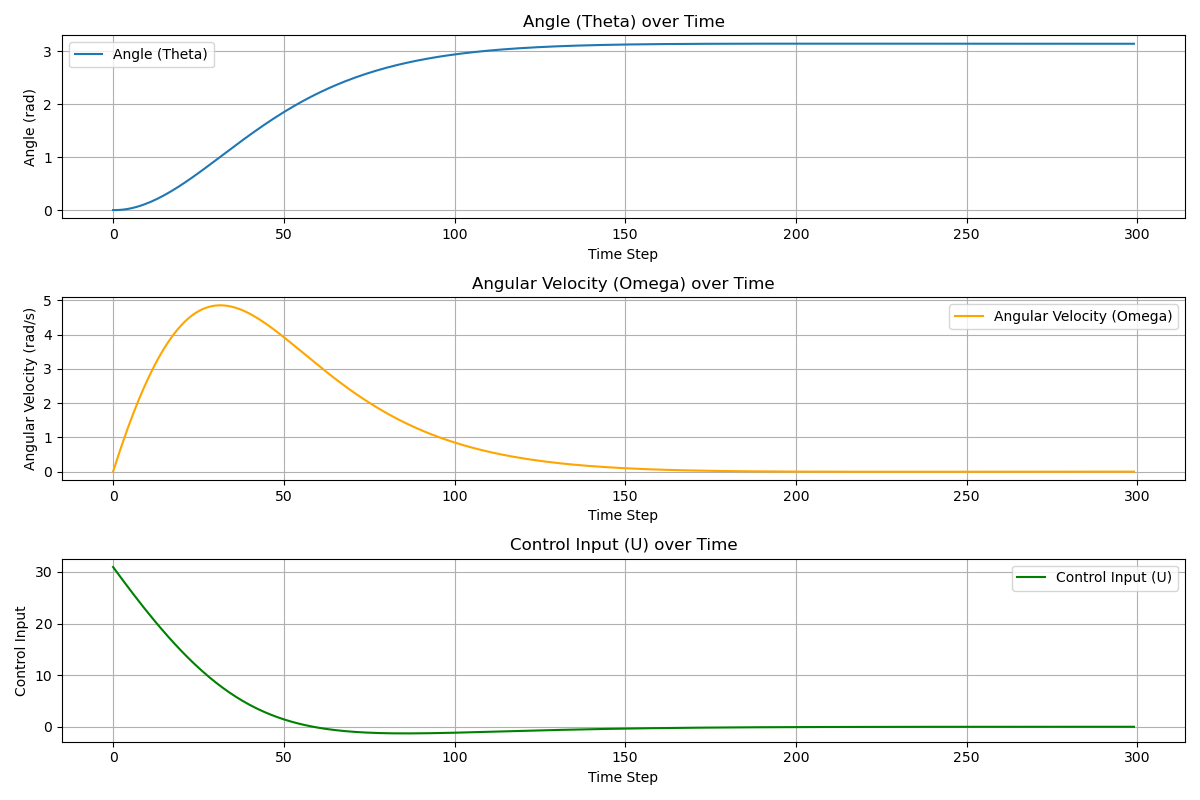

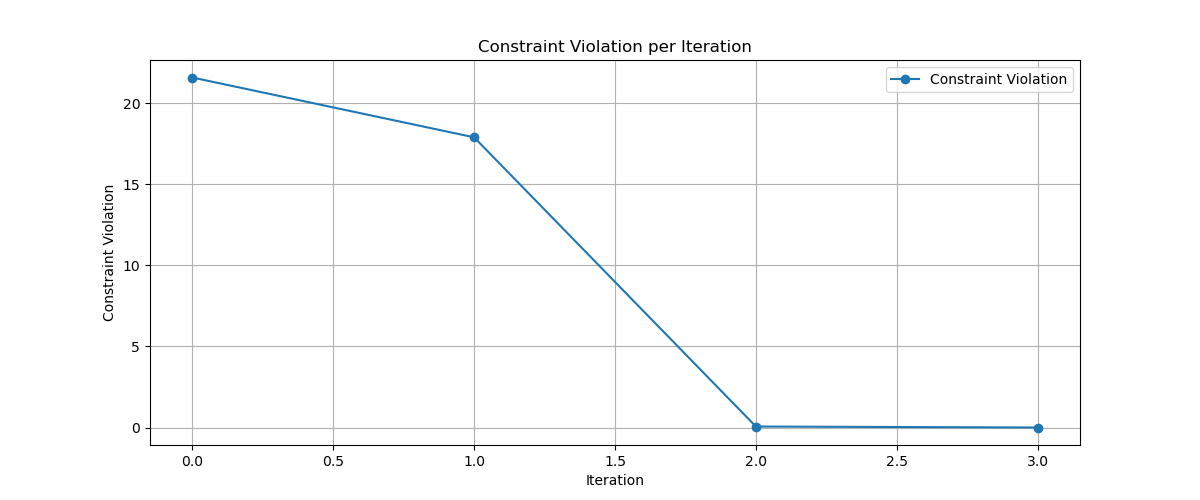

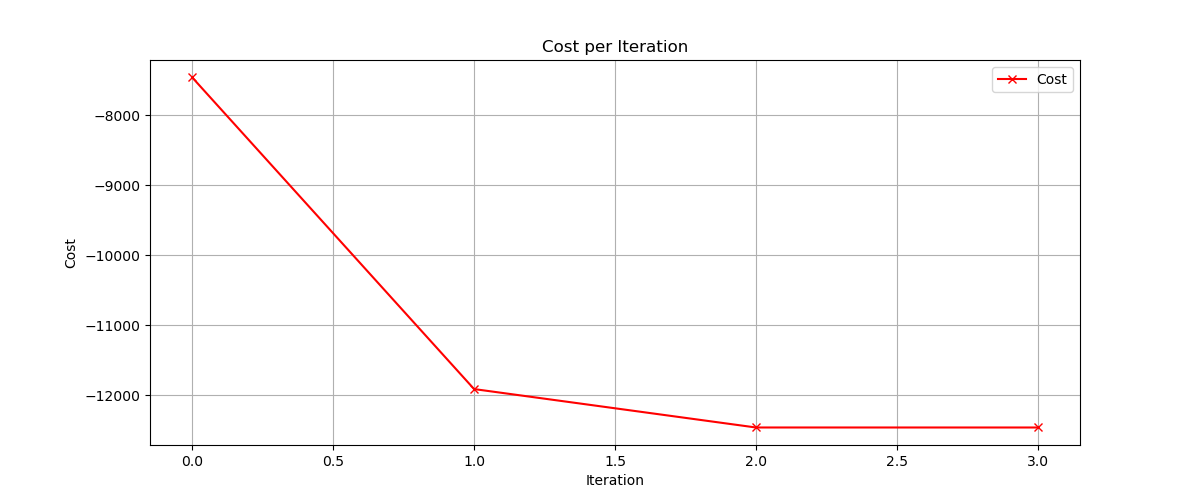

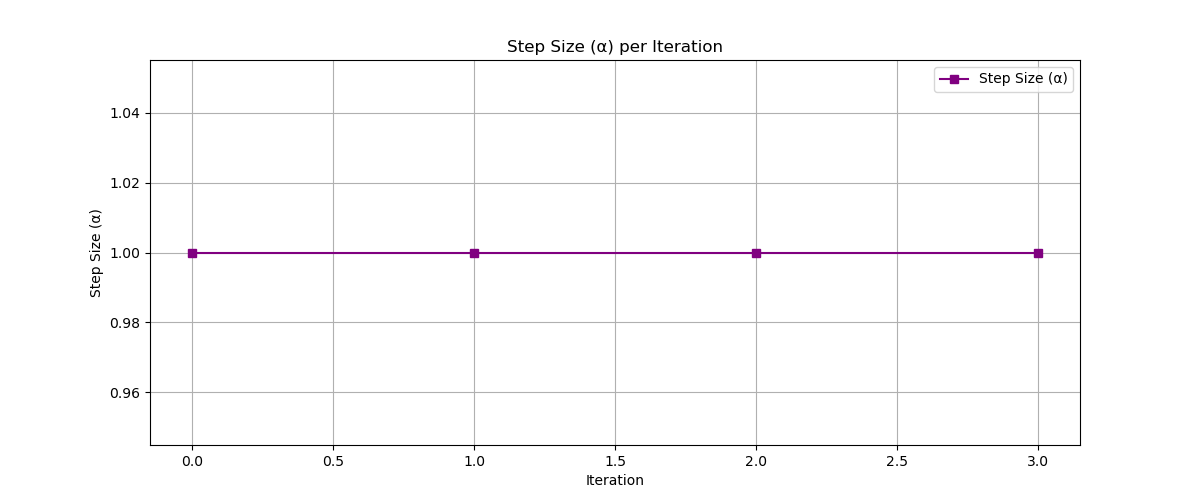

In [18]:
##SOLUTION PART 1 ( Question 1 )

# Import necessary libraries
%matplotlib widget
delta_t = pendulum.dt
gravity = pendulum.g 
tol = 1e-4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum 

# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
N1 = 300
u_new = np.zeros((N,1))
x_init = np.array([[1.0],[0.]])
pendulum.animate_robot(x_init, u_new.T)

# We don't want to print every decimal!
np.set_printoptions(suppress=True, precision=4)
                    

def create_block_diagonal(Q, N):
    # Initialize a zero matrix for G of shape (3*N, 3*N) as we know Q is its only unit
    G = np.zeros((3 * N, 3 * N))
    for i in range(N):
        G[i * 3:(i + 1) * 3, i * 3:(i + 1) * 3] = Q
    return G

def funtion_of_cost(x_x: np.ndarray, N=300):
    # Define the Q
    Q = np.array([
        [10, 0, 0],
        [0, 0.1, 0],
        [0, 0, 0.1]
    ])

    # Define the desired state vector x_des
    x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

    # Construct the block diagonal matrix G with N copies of Q along the diagonal
    G = create_block_diagonal(Q, N)

    # Compute the vector g by repeating (-x_des.T @ Q) N times
    g = np.tile((-x_des.T @ Q).flatten(), N).reshape(-1, 1)

    return (0.5 * (x_x.T @ G @ x_x) + (g.T @ x_x))[0, 0]
    
def compute_G_g(x_x: np.ndarray, N=300):
    # Initialize the G for the g(x)

    G = np.eye(2, 3 * N)
    # Initialize the residual vector g with zeros for the initial constraints
    # Shape: (2, 1)
    g = np.zeros((2, 1), dtype=np.float64)

    G[0, 0] = 1
    G[1, 1] = 1

    # The loop increments by 3 for xn  because variables are ordered as [theta_x, omega_x, u_x]
    for i in range(0, (N - 1) * 3, 3):
        # Extract the current state and control from x_x
        x_theta_i = x_x[i]       # theta_n
        x_omega_i = x_x[i + 1]   # omega_n
        x_u_i = x_x[i + 2]       # u_n
        x_theta_n11 = x_x[i + 3]  # theta_{n+1}
        x_omega_n11 = x_x[i + 4]  # omega_{n+1}
        G_i = np.zeros((2, N * 3))
        G_i[0, (i // 3) * 3:(i // 3) * 3 + 6] = [1, delta_t, 0, -1, 0, 0]
        G_i[1, (i // 3) * 3:(i // 3) * 3 + 6] = [-(delta_t * gravity * np.cos(x_theta_i[0])), 1, delta_t, 0, -1, 0]
        # Vertically stack the new constraints into the Jacobian matrix G
        G = np.vstack((G, G_i))
        residual_theta = x_theta_i + (delta_t * x_omega_i) - x_theta_n11

# Residual for omega constraint
        residual_omega = x_omega_i + (delta_t * (x_u_i - (gravity * np.sin(x_theta_i)))) - x_omega_n11

# Create an expanded array to accommodate the new residuals
        current_size = g.shape[0]
        new_size = current_size + 2  # Two new residuals
        g_expanded = np.zeros((new_size, g.shape[1]))  # Create an expanded array

# Copy existing values from g to the new array
        g_expanded[:current_size] = g

# Assign the new residuals directly to the end of the array
        g_expanded[current_size, 0] = residual_theta
        g_expanded[current_size + 1, 0] = residual_omega

# Update g to the new expanded array
        g = g_expanded

    return G, g
Q = np.array([
        [10, 0, 0],
        [0, 0.1, 0],
        [0, 0, 0.1]
    ])
x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

def cost_grad(x_x: np.ndarray,Q,x_des, N=300):
    G = create_block_diagonal(Q, N)
    
    g = np.tile((-x_des.T @ Q).flatten(), N).reshape(-1, 1)

    # Compute and return the gradient of the cost function: ∇f(x) = G * x_x + g

    return ((G @ x_x) + g)
    
def compute_hessian_L(N=300):
    return block_diag(*([np.array([[10, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])] * N))


def solve_KKT_eq_constr(x_x: np.ndarray):
    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    
    L_hessian_matrix = compute_hessian_L()

    # Compute the matrix of the constraints 

    constjacob, const_mat = compute_G_g(x_x=x_x)

    # calcuate gradient of the cost function
    constgrad = cost_grad(x_x,Q,x_des)

    num_constraints = constjacob.shape[0]
    
# Create a zero matrix of appropriate shape
    zero_matrix = np.zeros((num_constraints, num_constraints))

# create the KKT matrix by initializing an empty array 
    KKT = np.zeros((L_hessian_matrix.shape[0] + num_constraints, 
                 L_hessian_matrix.shape[1] + num_constraints))

# Fill in the blocks
    KKT[:L_hessian_matrix.shape[0], :L_hessian_matrix.shape[1]] = L_hessian_matrix
    KKT[:L_hessian_matrix.shape[0], L_hessian_matrix.shape[1]:] = constjacob.T
    KKT[L_hessian_matrix.shape[0]:, :L_hessian_matrix.shape[1]] = constjacob
    KKT[L_hessian_matrix.shape[0]:, L_hessian_matrix.shape[1]:] = zero_matrix
    # Assemble the right-hand side (RHS) of the KKT system
    # The RHS vector combines the negative gradient of the cost and the negative constraint residuals
    final = np.vstack((-constgrad, -const_mat))

    # Solve the KKT system to obtain the search direction `k_new` and the updated Lagrange multipliers `lambda_kp1`
    solution = np.linalg.solve(KKT, final)

    # Extract the search direction for the optimization variables from the solution
    # Assumes that the first 3*N elements correspond to `k_new`
    k_new = solution[:3*N1, 0]

    # Extract the updated Lagrange multipliers from the solution
    # Assumes that the remaining elements correspond to `lambda_kp1`
    lambda_kp1 = solution[3*N1:, 0]

    return k_new, lambda_kp1
def tot_constvoilation_eq(x_x: np.ndarray):
    # Compute the Jacobian matrix of the constraints and the constraint residuals at `x_x`
    _, g = compute_G_g(x_x)

    # Calculate the total constraint violation by summing the absolute values of the residuals
    total_violation = np.sum(abs(g))

    return total_violation
# Initialize the guess for the decision variables (theta, omega, control inputs)
# Assuming each time step has 3 variables: theta (angle), omega (angular velocity), and u (control input)
# Therefore, for N1 time steps, the total number of variables is 3*N1
x_guess = np.zeros((3 * N1, 1))  # Initial guess set to zero for all variables

# Initialize the guess for the Lagrange multipliers (dual variables)
# There are two equality constraints per time step: dynamics for theta and omega
# Additionally, there are 2*N1 inequality constraints for control input bounds (u_max and u_min)
# Initial guess set to zero for all dual variables
lambda_guess = np.zeros(((2 + (2 * N1)), 1))

# Initialize line search parameters
alpha = 1       # Initial step size
rho = 0.5       # Reduction factor for step size during backtracking line search

# Initialize best cost and constraint violation to infinity
# These will be updated to keep track of the best (lowest) cost and lowest constraint violation achieved
c_best = np.inf  # Best (minimum) constraint violation found so far
cost_best = np.inf  # Best (minimum) cost found so far

# Initialize history lists to store cost, step size (alpha), and constraint violations across iterations
coststeps = []      # List to store the cost at each iteration
alphasteps = []     # List to store the step size alpha at each iteration
csteps = []         # List to store the constraint violation at each iteration

# Start the Sequential Quadratic Programming (SQP) optimization loop
for i in range(0, N1):
    # Solve the Karush-Kuhn-Tucker (KKT) conditions to obtain the search direction (k_new) and dual variables (Lambda_new)
    # This function should return the step direction and updated dual variables based on current guess
    k_new, Lambda_new = solve_KKT_eq_constr(x_guess)

    # Reshape k_new to ensure it has the correct dimensions (3*N1 x 1)
    # The number 900 implies that N1 = 300; however, it's better to use 3*N1 for flexibility
    k_new = k_new.reshape(900, 1)  # Reshaping the search direction vector

    # Perform backtracking line search to find an appropriate step size (alpha)
    # The line search aims to ensure that both the cost decreases and constraint violations are minimized
    while ((funtion_of_cost(x_guess + (alpha * k_new)) > cost_best) &
           (tot_constvoilation_eq(x_guess + (alpha * k_new)) > c_best)):
        # Reduce the step size by multiplying with rho (0.5)
        alpha = rho * alpha

    # Update the best constraint violation and best cost based on the new candidate solution
    # Compute total constraint violation
    c_best = tot_constvoilation_eq(x_guess + (alpha * k_new))
    # Compute the cost of the new candidate solution
    cost_best = funtion_of_cost(x_guess + (alpha * k_new))

    # Record the history of cost, alpha, and constraint violation for analysis
    alphasteps.append(alpha)          # Store the current step size
    # Store the current constraint violation
    csteps.append(c_best)
    coststeps.append(cost_best)       # Store the current cost

    # Update the current guess of the decision variables by taking a step in the direction of k_new scaled by alpha
    x_guess = x_guess + (alpha * k_new)  # Update the solution vector

    # Check if the current constraint violation is below the specified tolerance (tol)
    if (c_best < tol):
        break  # If constraints are sufficiently satisfied, terminate the optimization loop

    # Update the guess for the dual variables (Lagrange multipliers) using a convex combination
    # This helps in stabilizing the dual variable updates
    lambda_guess = ((1 - alpha) * lambda_guess) + \
        (alpha * Lambda_new)  # Update dual variables

# After completing the iterations, print the total number of iterations performed
print(f"Total iterations completed = {i+1}")

# Extract the optimized variables for analysis and visualization
# Assuming the ordering of variables in x_guess is [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N1-1, omega_N1-1, u_N1-1]
# Extract theta (angle) variables every 3 steps starting at index 0
theta = x_guess[0::3].T
# Extract omega (angular velocity) variables every 3 steps starting at index 1
omega = x_guess[1::3].T
# Extract control input (u) variables every 3 steps starting at index 2
u_new = x_guess[2::3].T

# At this point, you can proceed to plot or analyze theta, omega, and control inputs as needed
# Display the animation
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, u_new)
# Plot all variables
# 1. Plotting the angles (theta)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(theta.flatten(), label='Angle (Theta)')
plt.title('Angle (Theta) over Time')
plt.xlabel('Time Step')
plt.ylabel('Angle (rad)')
plt.grid()
plt.legend()

# 2. Plotting the angular velocities (omega)
plt.subplot(3, 1, 2)
plt.plot(omega.flatten(), label='Angular Velocity (Omega)', color='orange')
plt.title('Angular Velocity (Omega) over Time')
plt.xlabel('Time Step')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid()
plt.legend()

# 3. Plotting the u_new
plt.subplot(3, 1, 3)
plt.plot(u_new.flatten(), label='Control Input (U)', color='green')
plt.title('Control Input (U) over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Input')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# 4. Plotting constraint violation per iteration
plt.figure(figsize=(12, 5))
plt.plot(csteps, label='Constraint Violation', marker='o')
plt.title('Constraint Violation per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Constraint Violation')
plt.grid()
plt.legend()
plt.show()

# 5. Plotting cost per iteration
plt.figure(figsize=(12, 5))
plt.plot(coststeps, label='Cost', color='red', marker='x')
plt.title('Cost per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

# 6. Plotting alpha (step size) per iteration
plt.figure(figsize=(12, 5))
plt.plot(alphasteps, label='Step Size (α)', color='purple', marker='s')
plt.title('Step Size (α) per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Step Size (α)')
plt.grid()
plt.legend()
plt.show()

C:\Users\Jainam\AppData\Local\Temp\ipykernel_25676\2345752551.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_expanded[current_size, 0] = residual_theta
C:\Users\Jainam\AppData\Local\Temp\ipykernel_25676\2345752551.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_expanded[current_size + 1, 0] = residual_omega


Total iterations needed = 46


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAX2VtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQ1liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFV
til7hBi79CSaTb0xDWuZN3nDq23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCK
Pg6PUsYPPJIyvfy6GBthd1X3VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrK
xbXWaoRrDbx+QTTsuhUA2e33z9YU6HaQ/iopLYQ5bZH9oDdnsb55tYCanIZrBIo4/vjG7G8VvmrU
eUbwMfc7oEWDcg2+4c5v0sc6J3GG3IncK0XM0MpnrGfqYO8ABZaLpfl07/Azf72gfzhGdnJe9UFl
PHPftj0JYFmzxJbGZ4tq5W0IMJZcaZ+qytfjqtBYwHi72Vi4Q+zbN0Watz3Sk6J470wKzk88jdQA
AAMAQegBriHGn49WnwX32oPYnQnn+kOKKLl8Y3SWZjTHvV4jC2q9W3Nkzk5YRBcLMkxJDzCQAz0g
WQqDMa7xhD52L7CKKG3xm8bh13y5Hv2oTUWp8CTml8VSdoHrM7pTCNIEMpNQzWUyatQUz06hWOkg
t971uPjOzmnqaYl5aiXI/pMgE+ajlf8mz05SKnolBbcTg1JxgDJOFsSrlFqt/zmg5VvX1lfOHath
cvpy7ed/vYUqjLvlvYNQWFbXVqwvSB187D1x3r/8vNSgrBvt+euGnfyL6MMiPMtsB8IKiSnnrR7o
YrWc9p6Ly4KNL7ZynNp9LGfmQZvPW/9e6S2omsxVxPmRkdZuDGfDGU5FoQf9T1cYLTVJN6LG/vr/
pdbTXm4Up/s9oC8N3O5ZDYiVcIpbp+RpovTr0MZf1ApNI4JZPgNJqtj9x7HiOc+JqSHAFDJ9mf9B
i5woQijyrAlvISqDdzVooE1i9jz4gKJJU2KEjShYCjBycndPQdOWB6lvKOJknWTWXdYOwrYXVQ5e
J6A7y3A5hDuu6J0InikJhgIlmf7TMtQaTZHhVjP8xMZbGwvv8hpHlyl4r6BTFivGfZL9zfCwTiDl
1A/3G66WTZsp4Qkpf/nPVYOGp7eAWn4zPmlHAATjdLwlUNkvrB1wW8d5fa77RH1qAzMoIALgWndg
d///Yhd1Arsw35Wvt+KQ4mnXonvdoo+XCWYUuvi/wvGv8td3Z0v5+n4WXO3shW41m7jhLw3wEOmF
qZtv7tnwbZ0BZqnv2TgT6n4rYEwROcvgM2nQVnYuC7vtDnRsIPYp8DkZPjafSr6UAGynEeVeFwwN
Q4aagOgMK/GVhHnSY0yDe2DPL52gpbtsFLrcJDalWGysiNmVkJcTgnp8v9DYaMshfEtSebuB697n
M3Nt2CS2ppoALdS5Z1vKOuWzzv8d7cPX+ktLGChDKLTQk4Nc7hVelL+n4HW0qifr+wTotrw/wMtV
N2DmqjYD5R2yvv8WNoSbKoPy7uYuPMGboeZkM9Y62jsQE0iBgtFcKLN9U2aIx5N0g2Y15TvCldHy
px9qyQbn5khNDapnLQV4nhjp3pENVuTESmky/V9Ue/2R7rbN7c3fFhjnzrZquWtj/Bl7cBlrb0W3
WlfooKWDZTYAZIKrVOhawPeXPB8TyLxNy2ANB7pYcSlTyjIPXrQc9DSbcVkF1A4ob2sEJciQXHVb
u5WlobUlRphptxUJqRMlf3sulBc3ILNCQXm4hKAS39xpJOsRND5bm/ZyHqqVFysUg+jTHg6RR68I
MJVhs+n1sCfi4ZbbnYk9IrZIqYX3Hy3xSP1HyWRZk2hVdmKT4CDRTiALv8aGKUKMMI/c50f+BTHr
NdZpqoXwgdYsyNazWbaJJKdUAKW/j8LzEGi6BYZhEg2KPYg5lpt5R22vOnXgEDM/0uaNOw/NN156
qWYB/QT5Vf5aSjEP5sVP/mAM9ATs535WDG7+xrKanGaytdps+xFYZxWKFL2xlO9Q66E32SZgH9V8
KzbKn17cPWpx3fTGHuarsJx81bDQ01/8YuWeupXaNzdCE3EuOyTBYHu06C+KX6I6Qel13C9fkb/w
FiK8U7ZQL5wynIrz5Wiw2uylrvtCcYAAILxxDTpKMK/CgYDhP1ar94bD/qUTttGexRj/T4iD4UO+
3kuxhcxeACiRbG8u8yLa4PqrOzhaM8F9KlDy6ilw/2EGmu3Uj+vVtVC4VTz4qeQY9JRcPUYvp8Kv
2TH37osm3RKMq/8IfyWrKRoExAj5MH1L2KOXWZDDSl/49S90ajlOalnt012sBlxIV7Y6Dnz3fRcf
OaJkfngJNHcProoBRzX8Ob7jiDypbMYjNZjcSifa64bXoSRX07ZuDHZqeuGB57a2yVFcr0Nj+TZZ
I8CRWz9/Yihhg8uaZ6I/+7yyrX0q+Y0dX9yee5IQIJBOIOqY7WOYh4jb1DCV+KwL1kgUrHZ3Dxh2
ElkBcoOeEwkVMmD5NEOSWP/lxTGKyOaen+xIHO4fpA2Iv0W6pWmIvjTZCSGNsvcJAifZ5LSk9TkM
xrOUz/+YBrq1B9Vaggn4Uf+BYWGQOM45lTJd4dgyH4hZDS+5a5qSAkIQx0TsHeK1OuKeoymKYojK
W9llaKG8L9OirryVUHfg9

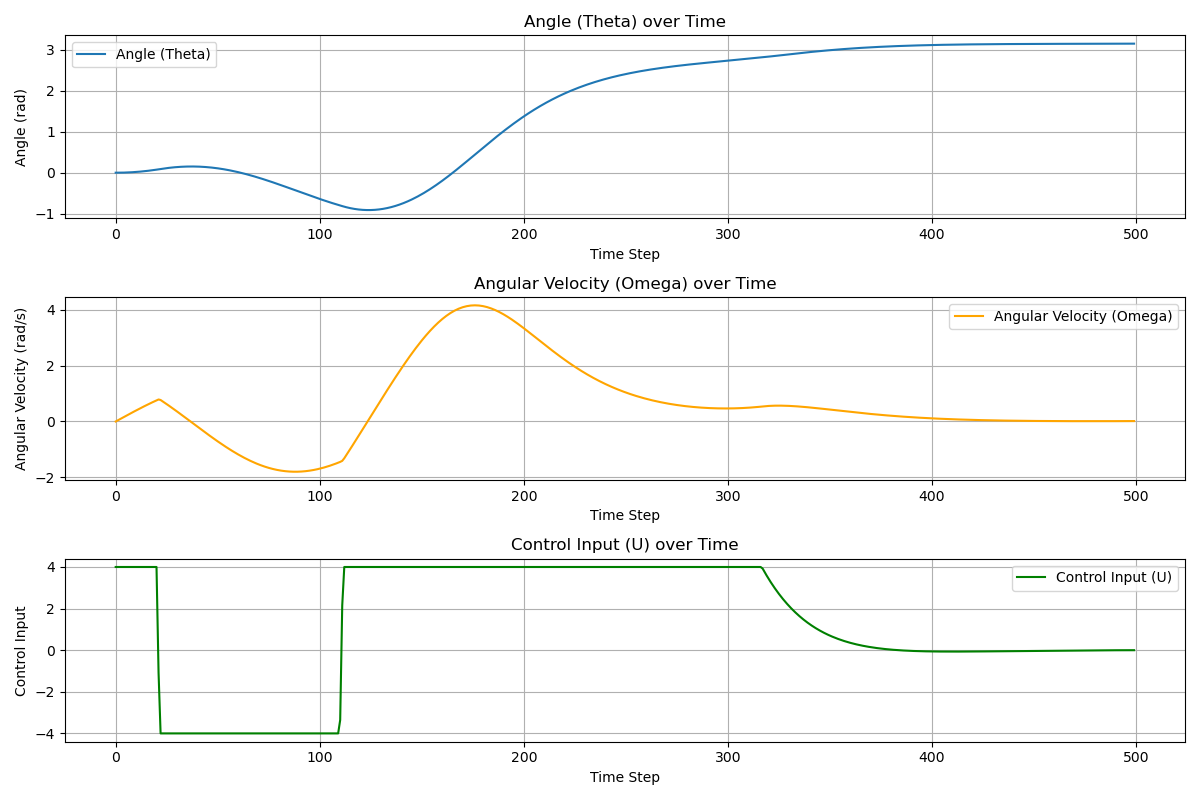

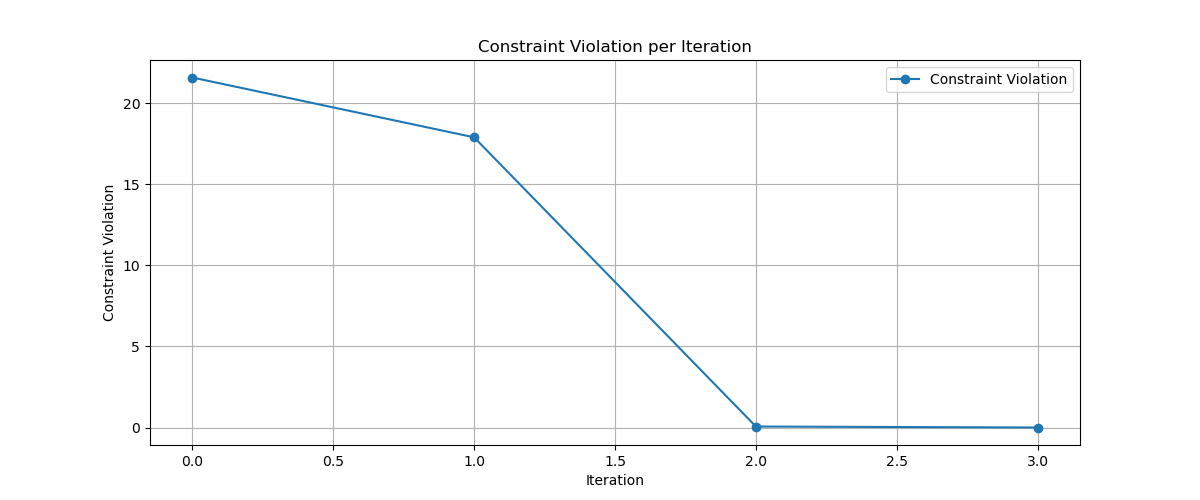

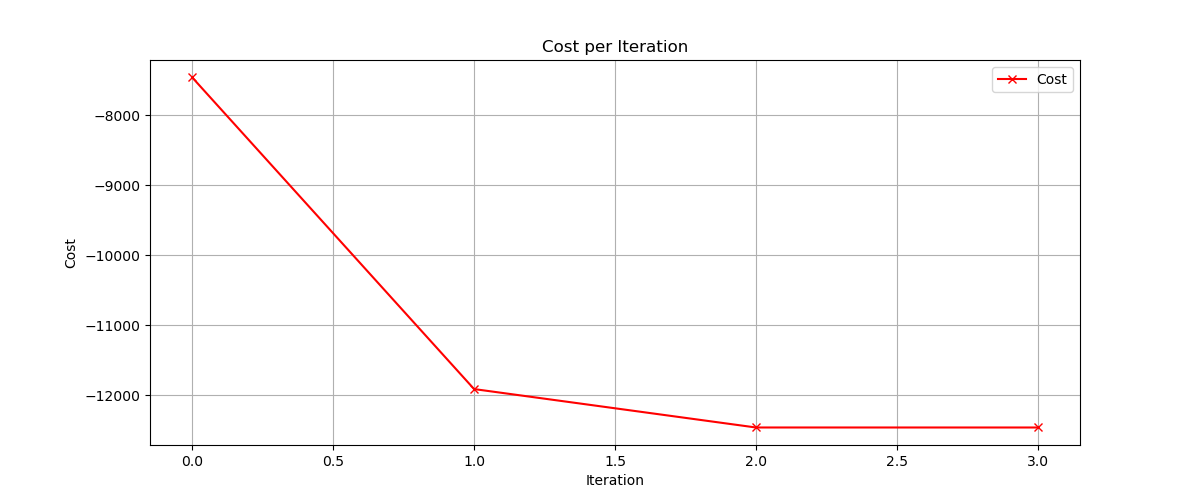

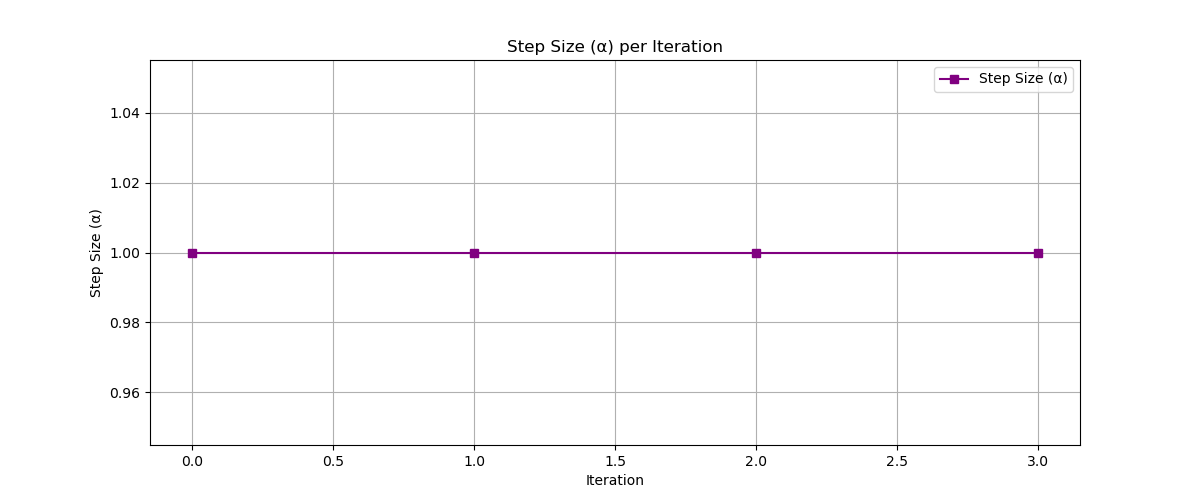

In [20]:
##SOLUTION PART 2 ( Question 2 )


N2 = 500

def form_ineq_const(x_x: np.ndarray, N=500):
    # Define the inequality constraint coefficients for a single time step.
    # Each control input u_n has two constraints:
    #   1. u_n <= 4  --> [0, 0, 1] * [theta_n, omega_n, u_n] <= 4
    #   2. -u_n <= 4 --> [0, 0, -1] * [theta_n, omega_n, u_n] <= 4
    C_i = np.array([
        [0, 0, 1],   # Coefficients for u_n <= 4
        [0, 0, -1]   # Coefficients for -u_n <= 4  (equivalent to u_n >= -4)
    ], dtype=np.float64)
    
    # Assuming H_i is defined and N is the number of blocks
    n = C_i.shape[0]  # Number of rows in H_i
    m = C_i.shape[1]  # Number of columns in H_i

    # Initialize a zero matrix for H of shape (N*n, N*m)
    C = np.zeros((N * n, N * m))

    for i in range(N):    # Place H_i in the right position in the block diagonal matrix
        C[i*n:(i+1)*n, i*m:(i+1)*m] = C_i

    # Extract the current control input values u_n from the solution vector x_x.
    # Assuming the variables are ordered as [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N-1}, omega_{N-1}, u_{N-1}],
    # the control inputs are located at indices 2, 5, 8, ..., which corresponds to slicing with a step of 3 starting from index 2.
    # Extract current u_n values as a 1D array of length N
    # Extract current u_n value
    u_k = x_x[2::3].flatten()

    # Initialize the h vector to store the upper bounds for each inequali
    # Create an empty array of length 2*N to hold all h valuesty constraint.
    # There are two constr
    # Create an empty array of length 2*N to hold all h values
    c = np.empty((2 * N,))

    # Populate the h vector with the appropriate bounds for each control input.
    for n in range(N):
        # Constraint 1: u_n <= 4
        # Reformulated as [0, 0, 1] * [theta_n, omega_n, u_n] <= 4
        c[2 * n] = 4 - u_k[n]    # Ensures that u_n does not exceed 4

        # Constraint 2: -u_n <= 4  (equivalent to u_n >= -4)
        # Reformulated as [0, 0, -1] * [theta_n, omega_n, u_n] <= 4
        c[2 * n + 1] = 4 + u_k[n]  # Ensures that u_n does not go below -4
    # Return the constructed inequality constraint matrix H and bounds vector h
    return C, c

def solve_KKT_eq_ineq_constr(x_x: np.ndarray):

    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    # The Hessian captures the second-order partial derivatives of the Lagrangian function,
    # which is essential for defining the curvature in the QP subproblem.
    L_hessian_matrix = compute_hessian_L(N=N2)

    # Compute the Jacobian matrix of the constraints and the residuals
    # G_eq represents the Jacobian of the equality constraints evaluated at the current guess `x_x`.
    # g_eq represents the residuals of the equality constraints, indicating how much the current guess
    # violates these constraints.
    constjacob, const_mat = compute_G_g(x_x=x_x, N=N2)

    # Compute the gradient of the cost function at the current guess `x_x`.
    # This gradient is used in the linear term of the QP's objective function.
    cost_grad_mat = cost_grad(x_x,Q,x_des, N=N2)

    # Formulate the inequality constraints for the QP.
    # `form_ineq_const(x_x=x_x)` returns a tuple where:
    # - The first element is the inequality constraint matrix G (shape: [2*N2, 3*N2]).
    # - The second element is the inequality constraint bounds vector h (shape: [2*N2,]).
    G_ineq, c_ineq = form_ineq_const(x_x=x_x)

    # Create the Quadratic Programming (QP) problem instance using the `Problem` class from `qpsolvers`.
    # The QP is defined as:
    #   minimize (1/2) * p.T * P * p + q.T * p
    #   subject to A * p = b
    #              G * p <= h
    problem = Problem(P=L_hessian_matrix, q=cost_grad_mat, A=constjacob, b=-const_mat.flatten(), G=G_ineq ,h=c_ineq.flatten() )

    # Solve the QP problem using the 'cvxopt' solver.
    # The solver attempts to find the optimal step direction `pk` that minimizes the QP's objective
    # while satisfying both equality and inequality constraints.
    solution = solve_problem(problem=problem,solver="cvxopt",initvals=None)

    # Check if the solver successfully found a solution.
    if solution is None:
        # If the solver fails (e.g., due to infeasibility or numerical issues), raise an error.
        raise ValueError("QP solver failed to find a solution")

    # Return the solution object containing the optimal step direction and dual variables.
    return solution

def tot_constvoilation_eq_ineq(x_x: np.ndarray, verbose=False):
    # Compute the total violation for equality constraints
    # `compute_G_g(x_x, N=N2)` returns a tuple where the second element is the residuals of equality constraints
    # Taking the absolute value of each residual and summing them gives the total equality constraint violation
    constvoilation_eq = np.sum(abs(compute_G_g(x_x, N=N2)[1]))

    # Extracting the control values (u_n) for the question
    u = x_x[2::3].flatten()

    # Initialize the total inequality constraint violation
    constvoilation_ineq = 0

    # Iterate over each control input to calculate inequality violations
    for u_i in u:
        if u_i > 4:
            # If the control input exceeds the upper bound, accumulate the violation amount
            constvoilation_ineq += np.abs(u_i - 4)
        elif u_i < -4:
            # If the control input is below the lower bound, accumulate the violation amount
            constvoilation_ineq += np.abs(-u_i - 4)


    # Return the sum of equality and inequality constraint violations as the total violation
    return constvoilation_eq + constvoilation_ineq


x_guess = np.zeros((3 * N2, 1))  # Shape: (3*N2, 1)

# Initialize `alpha` as 1 for the line search algorithm
alpha = 1  

# Set the reduction factor `rho` to 0.5 for line search
rho = 0.5  

# Initialize the best (minimum) constraint violation encountered so far to infinity
c_best = np.inf  

# Initialize the best (minimum) cost encountered so far to infinity
cost_best = np.inf  

# Initialize lists to keep track of the history of costs, new alpha values, and constraint violations
cost_steps = []      
alpha_steps = []    
c_steps = []       

# Begin the main optimization loop, iterating up to N2 times
for i in range(0, N2):
    # Solve the Karush-Kuhn-Tucker (KKT) conditions to obtain the search direction `pk`
    # The function `solve_KKT_eq_ineq_constr` returns an object with the optimal solution `solution.x`
    solution = solve_KKT_eq_ineq_constr(x_guess)

    # Reshape the solution vector `solution.x` to match the shape of `x_guess`
    # `pk` represents the search direction for updating `x_guess`
    pk = solution.x.reshape(N2 * 3, 1)  # Shape: (3*N2, 1)

    # Perform backtracking line search to find an appropriate step size `alpha`
    # The loop continues reducing `alpha` until both the cost decreases and constraint violations are reduced
    while ((funtion_of_cost(x_x=(x_guess + (alpha * pk)), N=N2) >= cost_best) &(tot_constvoilation_eq_ineq(x_x=(x_guess + (alpha * pk))) >= c_best)):
        alpha = rho * alpha  # Reduce the step size by the factor `rho`

    # Update the best constraint violation with the new candidate solution
    c_best = tot_constvoilation_eq_ineq(
        (x_guess + (alpha * pk)), verbose=False)  # Calculates total constraint violation

    # Update the best cost with the new candidate solution
    cost_best = funtion_of_cost((x_guess + (alpha * pk)),
                          N=N2)  # Calculates the cost

    # Append the current step size, constraint violation, and cost to their respective history lists
    alpha_steps.append(alpha)          # Record the step size
    c_steps.append(c_best)             # Record the constraint violation
    cost_steps.append(cost_best)       # Record the cost

    # Update the decision variable vector `x_guess` by taking a step in the direction of `pk`
    x_guess = x_guess + (alpha * pk)  # Shape: (3*N2, 1)

    # Extract the theta (angle) values from the updated `x_guess` vector
    # Assumes theta values are at indices 0, 3, 6, ..., i.e., every 3rd element starting from 0
    theta = x_guess[0::3].T  # Shape: (1, N2)

    # Extract the omega (angular velocity) values from the updated `x_guess` vector
    # Assumes omega values are at indices 1, 4, 7, ..., i.e., every 3rd element starting from 1
    omega = x_guess[1::3].T  # Shape: (1, N2)

    # Extract the control input `u` values from the updated `x_guess` vector
    # Assumes u values are at indices 2, 5, 8, ..., i.e., every 3rd element starting from 2
    u_new = x_guess[2::3].T  # Shape: (1, N2)

    # Check if the current constraint violation is below the specified tolerance
    if (c_best < tol):
        break  # Terminate the loop early if convergence is achieved

# After completing the iterations, print the total number of iterations performed
print(f"Total iterations needed = {i+1}")

# Extract the final optimized variables for further analysis or visualization
# These lines appear redundant as they are already inside the loop, but are retained as per the original code
theta2 = x_guess[0::3].T      # Shape: (1, N2)
omega2 = x_guess[1::3].T      # Shape: (1, N2)
u_new2 = x_guess[2::3].T    # Shape: (1, N2)

x_init2 = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init2, u_new2)
# Plot all variables
# 1. Plotting the angles (theta)
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(theta.flatten(), label='Angle (Theta)')
plt.title('Angle (Theta) over Time')
plt.xlabel('Time Step')
plt.ylabel('Angle (rad)')
plt.grid()
plt.legend()

# 2. Plotting the angular velocities (omega)
plt.subplot(3, 1, 2)
plt.plot(omega.flatten(), label='Angular Velocity (Omega)', color='orange')
plt.title('Angular Velocity (Omega) over Time')
plt.xlabel('Time Step')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid()
plt.legend()

# 3. Plotting the u_new
plt.subplot(3, 1, 3)
plt.plot(u_new.flatten(), label='Control Input (U)', color='green')
plt.title('Control Input (U) over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Input')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# 4. Plotting constraint violation per iteration
plt.figure(figsize=(12, 5))
plt.plot(csteps, label='Constraint Violation', marker='o')
plt.title('Constraint Violation per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Constraint Violation')
plt.grid()
plt.legend()
plt.show()

# 5. Plotting cost per iteration
plt.figure(figsize=(12, 5))
plt.plot(coststeps, label='Cost', color='red', marker='x')
plt.title('Cost per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

# 6. Plotting alpha (step size) per iteration
plt.figure(figsize=(12, 5))
plt.plot(alphasteps, label='Step Size (α)', color='purple', marker='s')
plt.title('Step Size (α) per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Step Size (α)')
plt.grid()
plt.legend()
plt.show()